In [1]:
import import_ipynb                #pip install import_ipynb
from NimbRoNet2 import *
from Utils import *
from Transformation import *
from CustomDataset import *
import torch
import sys
import torch.optim as optim
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

batch_size = 5

print("Device : ",avDev)
print("Python Version : ",sys.version)
print("Pytorch Version : ",torch.__version__)

importing Jupyter notebook from NimbRoNet2.ipynb
importing Jupyter notebook from Utils.ipynb
importing Jupyter notebook from Transformation.ipynb
importing Jupyter notebook from CustomDataset.ipynb
Device :  cuda
Python Version :  3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
Pytorch Version :  1.3.1


Blob Train Dataset :  3598
Segmentation Train Dataset :  1108
torch.Size([5, 3, 480, 640])


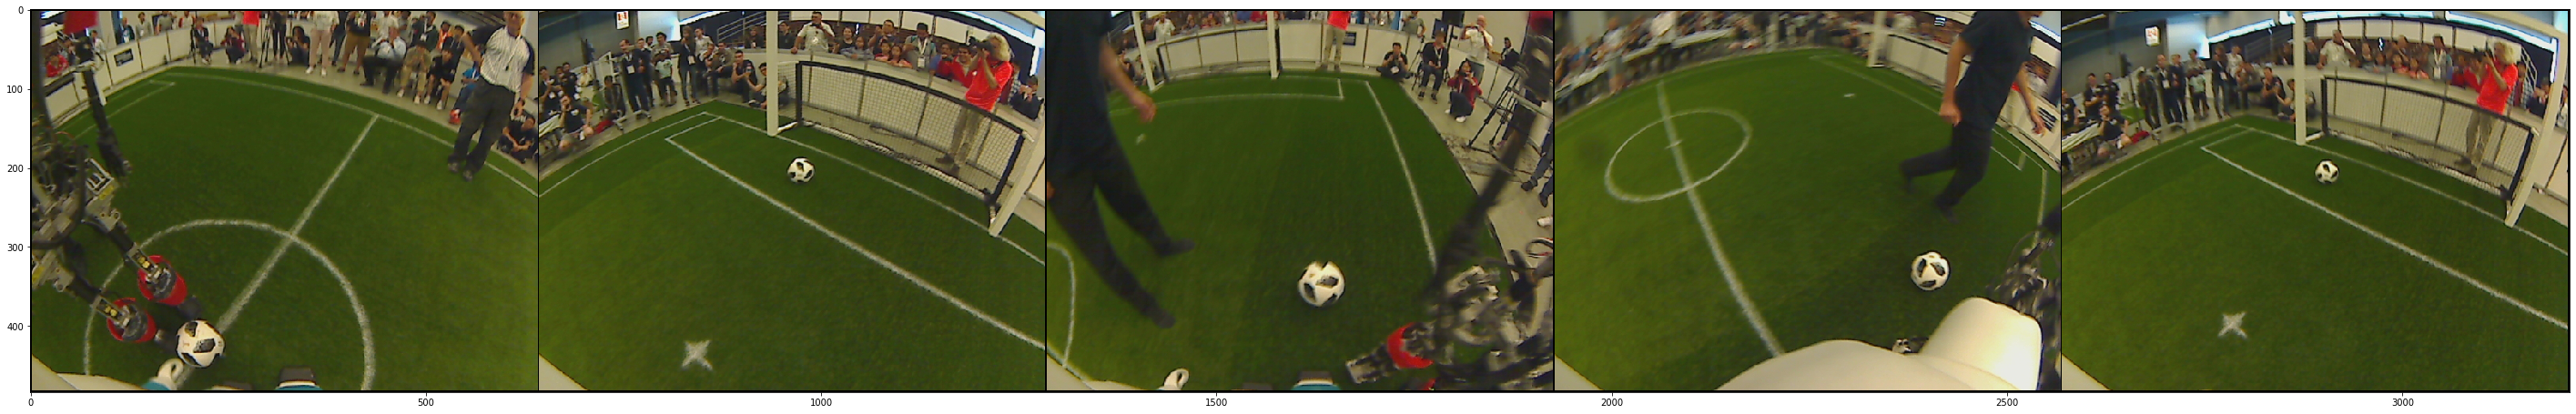

19200


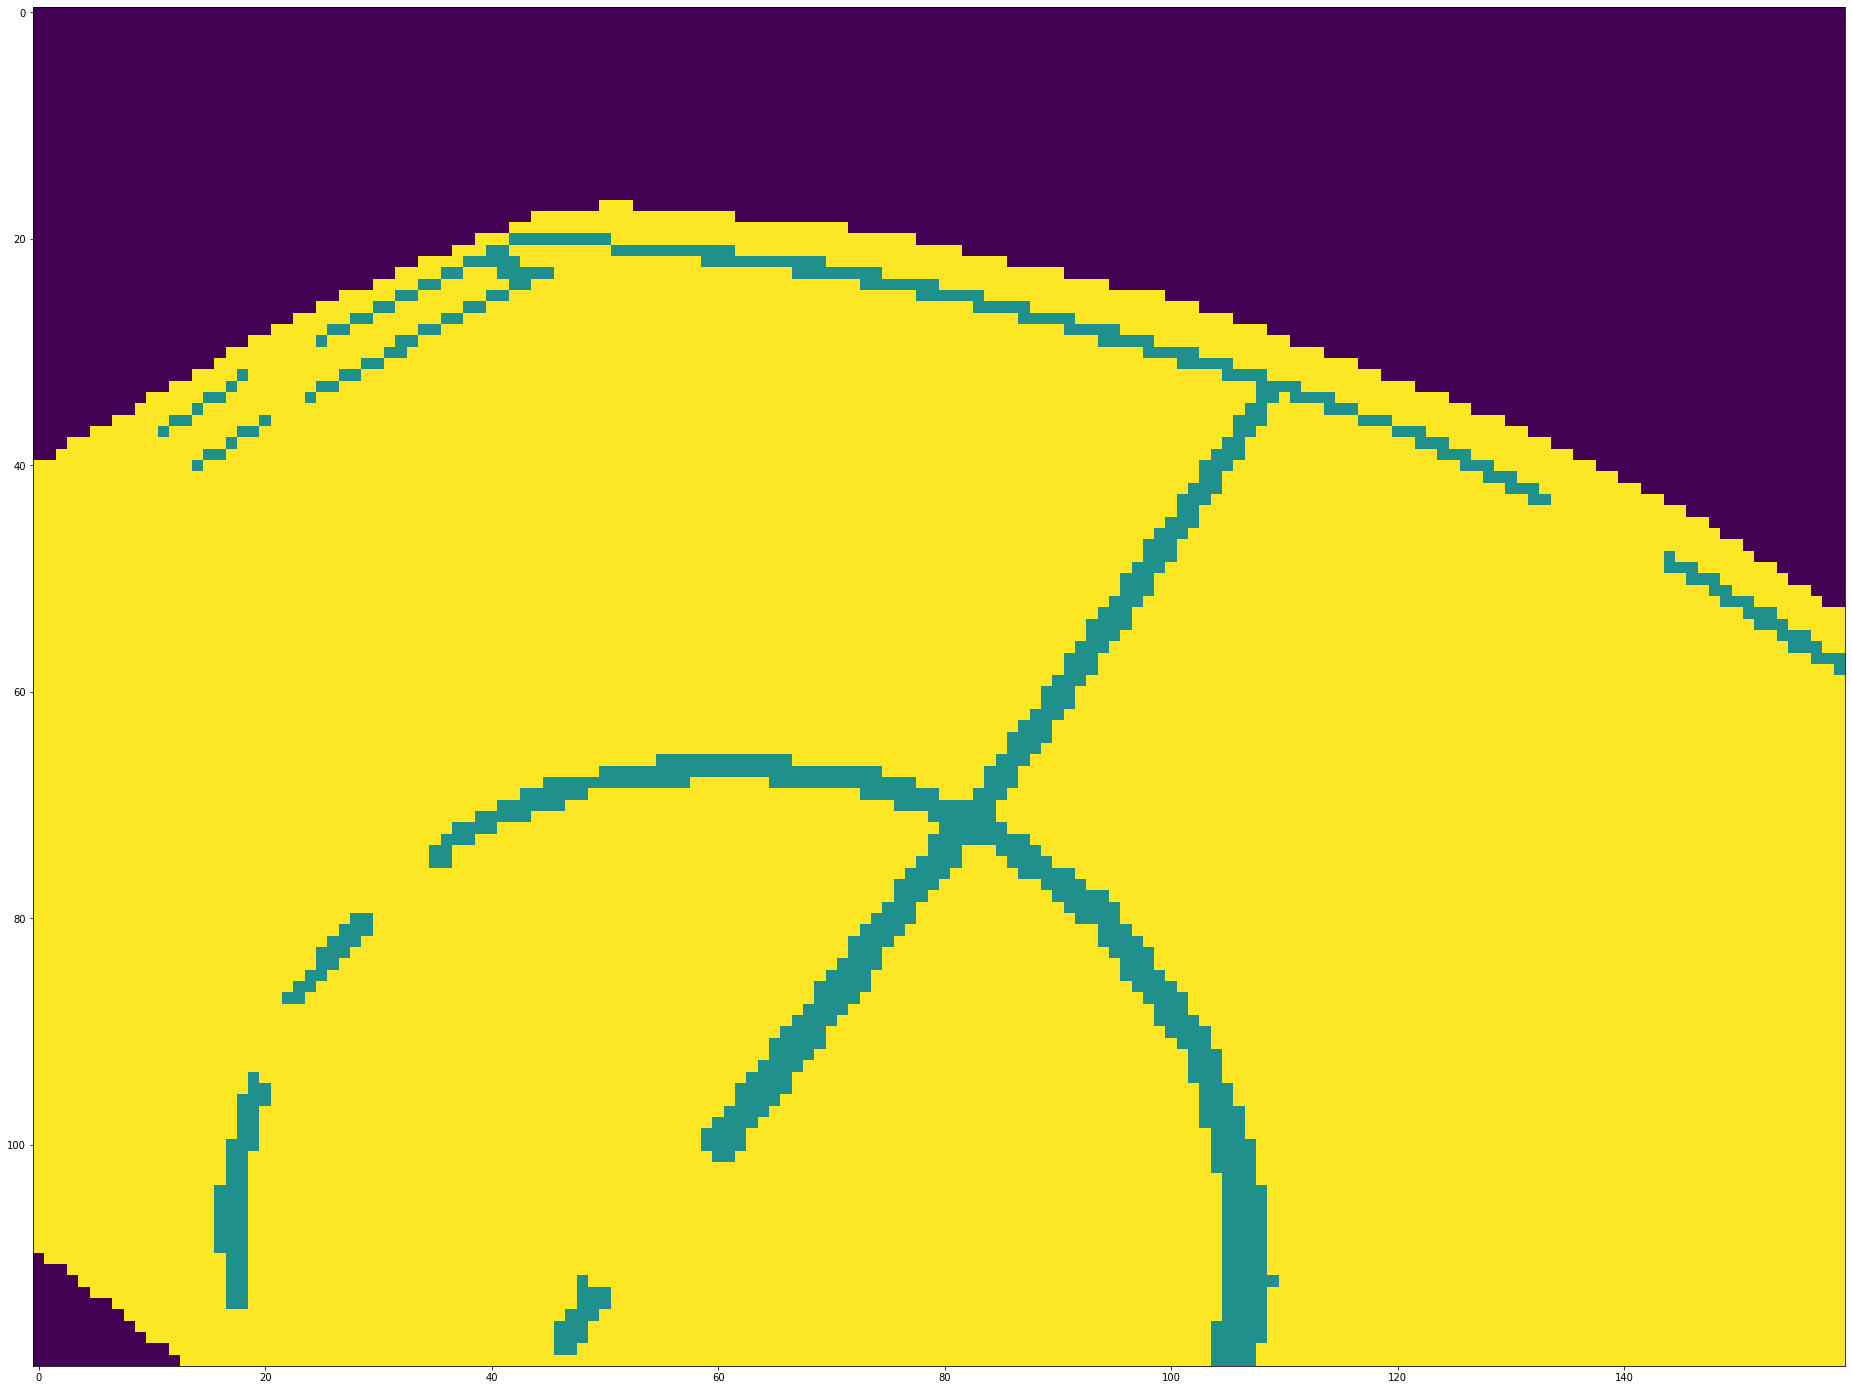

KeyboardInterrupt: 

In [3]:
train_transforms = [Rescale((480,640)),
              RandomVerticalFlip(),
              RandomHorizontalFlip(),
              ColorJitter(brightness=0.5, 
                          contrast=0.5, 
                          saturation=0.5,
                          hue = 0.5),
              ToTensor(),
              Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])]

train_dataset = BlobTrainDataset(path = '../Project/data/blob/forceTrain',transform=train_transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# print_dataloader(train_loader, num_of_image= 3, avDev = avDev)

print("Blob Train Dataset : ",len(train_dataset))

seg_train_dataset = SegDataset(path = '../Project/data/segmentation/dataset', transform= None)
seg_train_loader = torch.utils.data.DataLoader(dataset=seg_train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

print("Segmentation Train Dataset : ",len(seg_train_dataset))

for i, test_data in enumerate(seg_train_loader):

    plt.figure(figsize=(50,25))
    print(test_data[0].size())
    plt.imshow(torchvision.utils.make_grid(test_data[0], nrow=5).permute(1, 2, 0))
    plt.show()
    plt.figure(figsize=(50,25))
#     plt.imshow(torchvision.utils.make_grid(test_data[1], nrow=1).permute(1, 2, 0))
#     plt.imshow(torchvision.utils.make_grid(test_data[1][0], nrow=5).permute(1, 2, 0))
    plt.imshow(test_data[1][0].cpu().detach().numpy(), interpolation='nearest')
    print(test_data[1][0].cpu().detach().numpy().size)
    plt.show()
#     print(np.array(test_data[1][0]))
    raise KeyboardInterrupt

In [4]:
model = NimbRoNet2()
model.to(avDev)

criterion_blob = nn.MSELoss()
criterion_seg = nn.CrossEntropyLoss()

criterion_blob.to(avDev)
criterion_seg.to(avDev)

optimizer = optim.Adam([
                        {"params":model.e_block1.parameters(), "lr": 0.000001},
                        {"params":model.e_block2.parameters(), "lr": 0.000001},
                        {"params":model.e_block3.parameters(), "lr": 0.000001},
                        {"params":model.e_block4.parameters(), "lr": 0.000001},
                        {"params":model.d_block1.parameters()},
                        {"params":model.d_block2.parameters()},
                        {"params":model.d_block3.parameters()},
                        {"params":model.d_block4.parameters()},
                        {"params":model.conv_1_1.parameters()},
                        {"params":model.conv_1_2.parameters()},
                        {"params":model.conv_1_3.parameters()}], lr=0.001)

checkpoint = torch.load("../model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
no_epoch = checkpoint['epoch']
print("No of epoch : ",no_epoch)
train_loss_1 = checkpoint['train_loss1']

No of epoch :  9


In [ ]:
total_loss = 0.0
loss_details = [None]*100
train_loss = 0.0

combined_loader = [train_loader, seg_train_loader]

for epoch in range(no_epoch, no_epoch + 2):

    print("epoch",epoch)
    train_loss, model = train_model(model, "seg", combined_loader, criterion_blob, criterion_seg, optimizer, avDev)
    loss_details[epoch] = train_loss
    print("train loss",train_loss)
    total_loss += train_loss
    #print("total loss", total_loss)

  0%|          | 0/222 [00:00<?, ?it/s]

epoch 9


Utils.ipynb:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "import torchvision.transforms.functional as F\n",
  0%|          | 0/222 [00:00<?, ?it/s]

train loss 8.516554832458496
epoch 10


 74%|███████▍  | 164/222 [01:06<00:23,  2.46it/s]

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss1': loss_details,
#             }, "../model.pth")


In [ ]:
test_transforms = [Rescale((480,640)),
              ToTensor(), 
              Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])]

test_dataset = BlobTestDataset(path = '../Project/data/blob/forceTest',transform=test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=1, 
                                           shuffle=True)

seg_test_dataset = SegDataset(path = '../Project/data/segmentation/forceTrain',transform=None)
seg_test_loader = torch.utils.data.DataLoader(dataset=seg_test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# blob_test(model, test_loader, avDev)
# blob_test_output(model, test_loader, avDev)

total_test = 0
correct_test = 0

for i, test_data in enumerate(seg_test_loader):
    if(i <= 0):
        images = test_data[0].to(avDev)
        target = test_data[1].to(avDev)

        output = model(images)
        
        _,predicted = torch.max(output.data, 1)
        total_test += target.nelement()
        correct_test += predicted.eq(target.data).sum().item()
        test_accuracy = 100 * correct_test / total_test
        print("Accuracy : ", test_accuracy)
        
        for i in range(output.shape[0]):
        
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.title('Test image')
            #print(images[i].size())
            plt.imshow(np.transpose(images[i].cpu().detach().numpy(), (1, 2, 0)))
            plt.subplot(1,2,2)
            plt.title('Segmentaed Image')
            plt.imshow(np.transpose(output[i].cpu().detach().numpy(), (1, 2, 0)).mean(axis = 2), cmap = 'gray')
            #channel 0 background; 1 line; 2 ground
    #         plt.imshow(torchvision.utils.make_grid(output.cpu().detach()[0][2,:,:], nrow=5).permute(1, 2, 0))
            #plt.imshow(torchvision.utils.make_grid([1, 1, 1] - output.cpu().detach().numpy(), nrow=5).permute(1, 2, 0))
            plt.show()
    else:
        break

In [ ]:
for j,test_data in enumerate(seg_test_loader):
      
    images = test_data[0].to(avDev)
    label = test_data[1].to(avDev)
    
    images.requires_grad_(False)
    label.requires_grad_(False)
    
    batch = test_data['image'].shape[0]
    
    for i in range(5):
        k += 1
        plt.figure(figsize=(40,20))
        plt.subplot(2,3,1)
        plt.title('Test image' + str(k))
        plt.imshow(images[0][i].cpu())
        out = model(images)
        plt.subplot(2,3,2)
        plt.title('Ball')
        plt.imshow(out[i][0].cpu().detach().numpy(), cmap= 'gray')
        plt.subplot(2,3,3)
        plt.title('Goalpost')
        plt.imshow(out[i][1].cpu().detach().numpy(), cmap= 'gray')
        plt.subplot(2,3,5)
        plt.title('Robot')
        plt.imshow(out[i][2].cpu().detach().numpy(), cmap= 'gray')
        plt.show()